In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [ ]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

from desc import set_device
set_device("gpu")

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [5]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+435.gd8cb3406e.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.10 GB available memory.


# QH Results

In [28]:
eqfam = desc.io.load("eqfam_rotated_poincare_optimize_QH_wqs1.0_war50.0_wvol10.0.h5")

In [29]:
eq = eqfam[-1]
eq0 = eqfam[0]
eqh = get("precise_QH")
eq_rotated = eq.copy()
eq0_rotated = eq0.copy()
eq_rotated = rotate_zeta(eq_rotated, angle=np.pi / eq.NFP)
eq0_rotated = rotate_zeta(eq0_rotated, angle=np.pi / eq.NFP)

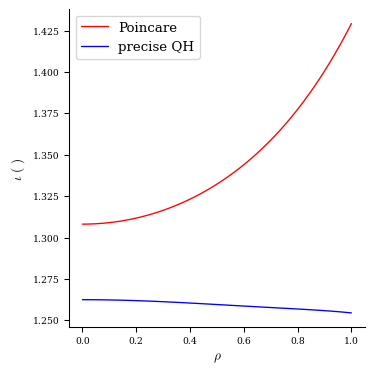

In [30]:
fig, ax = plot_1d(eq, "iota", label="Poincare", color="red")
plot_1d(eqh, "iota", ax=ax, label="precise QH", color="blue")
plt.savefig("iota_poincare_optimize_QH_wqs1.0_war50.0_wvol10.0.png", dpi=300)

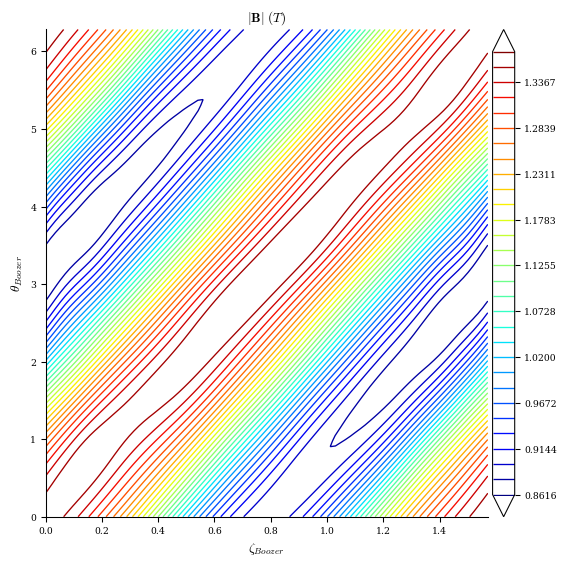

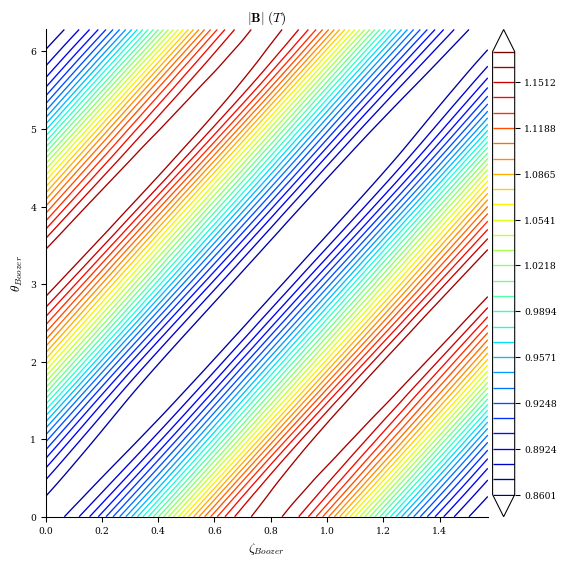

In [31]:
rho = 1
plot_boozer_surface(eq, rho=rho)
plt.savefig(
    f"boozer_rho{rho}_poincare_optimize_QH_wqs1.0_war50.0_wvol10.0.png",
    dpi=300,
)
plot_boozer_surface(eqh, rho=rho);

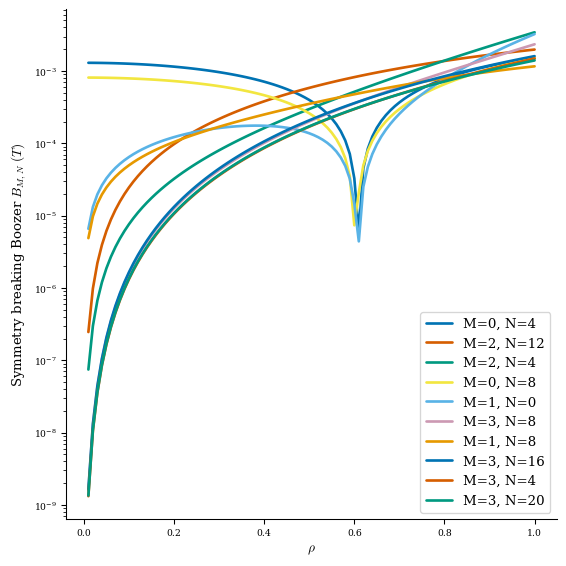

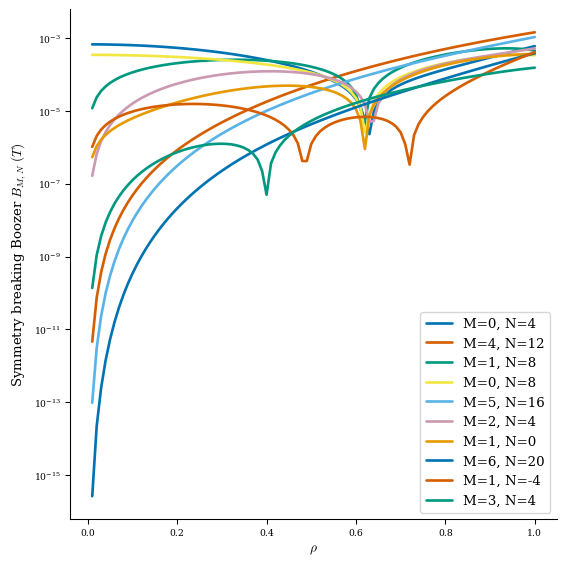

In [32]:
rho = 100
plot_boozer_modes(eq, helicity=(1, eq.NFP), rho=rho)
plot_boozer_modes(eqh, helicity=(1, eq.NFP), rho=rho);

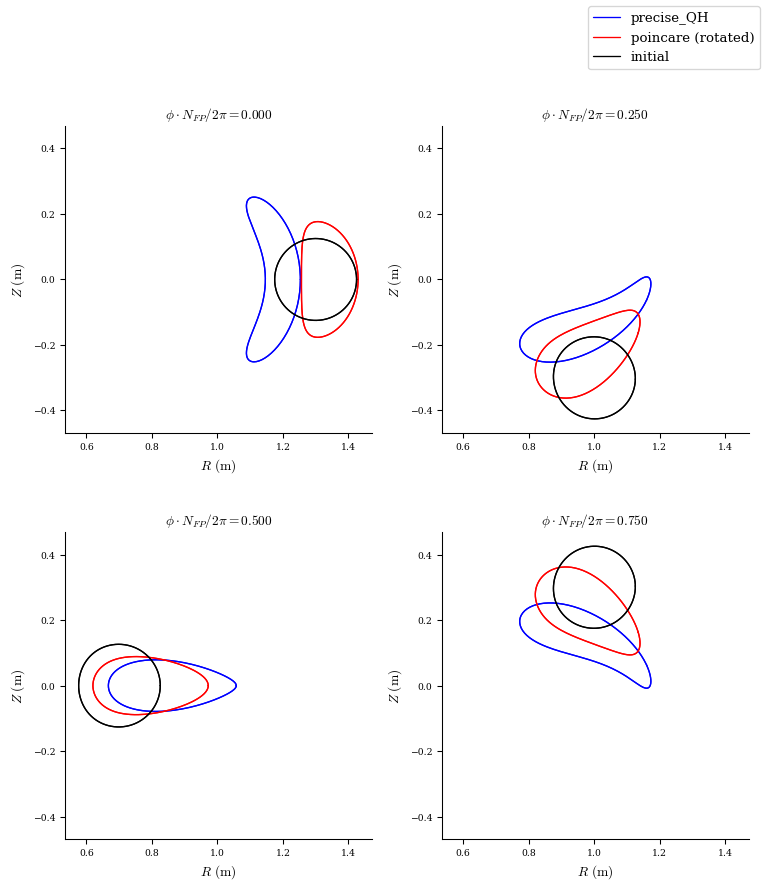

In [10]:
plot_comparison(
    [eqh, eq_rotated, eq0_rotated],
    labels=["precise_QH", "poincare (rotated)", "initial"],
    color=["blue", "red", "black"],
    theta=0,
    rho=1,
    phi=4,
)
plt.savefig(
    "surface_poincare_optimize_QH_wqs1.0_war50.0_wvol10.0.pdf", dpi=400
)

# QA Results

In [39]:
eqfam = desc.io.load("eqfam_poincare_optimize_QA_wqs1.0_war10.0_wvol10.0_wiota20.0.h5")
eq = eqfam[-1]
eq0 = eqfam[0]
eqh = get("precise_QA")
eq_rotated = eq.copy()
eq_rotated = rotate_zeta(eq_rotated, angle=np.pi / eq.NFP)

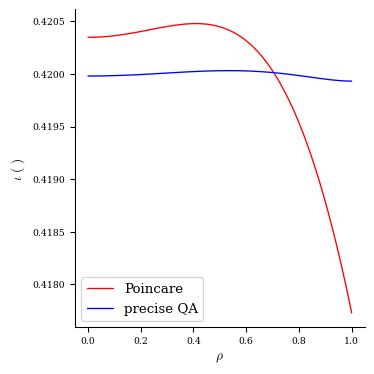

In [17]:
fig, ax = plot_1d(eq, "iota", label="Poincare", color="red")
plot_1d(eqh, "iota", ax=ax, label="precise QA", color="blue");
plt.savefig(
    "iota_poincare_optimize_QA_wqs1.0_war10.0_wvol10.0_wiota20.0.png", dpi=300
)

(<Figure size 576.113x576.113 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

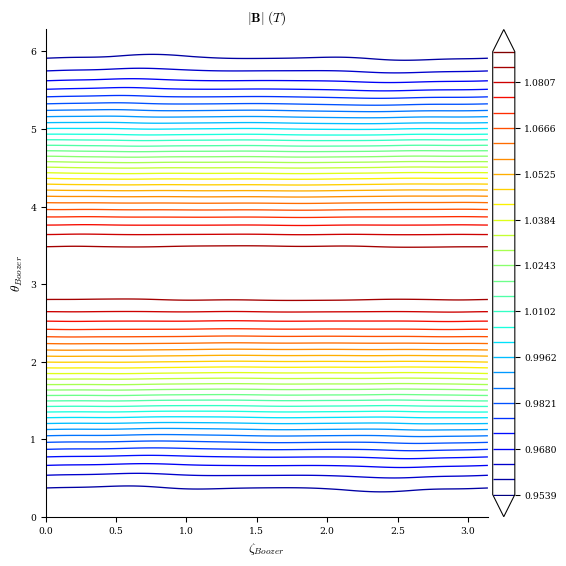

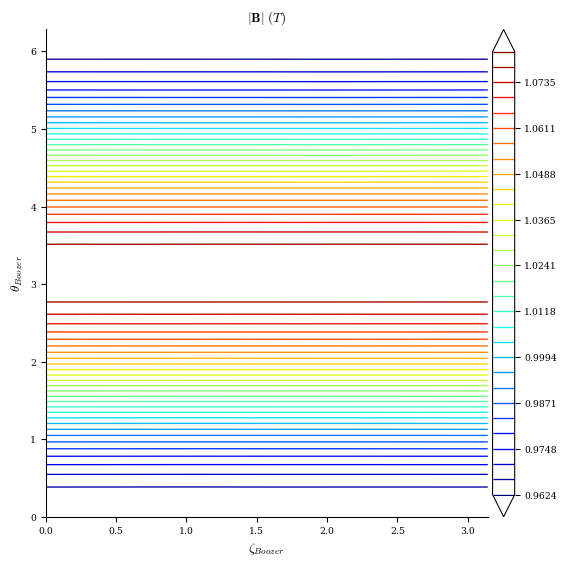

In [18]:
rho = 0.6
plot_boozer_surface(eq, rho=rho)
plt.savefig(f"boozer_rho{rho}_poincare_optimize_QA_wqs1.0_war10.0_wvol10.0_wiota20.0.png", dpi=300)
plot_boozer_surface(eqh, rho=rho)

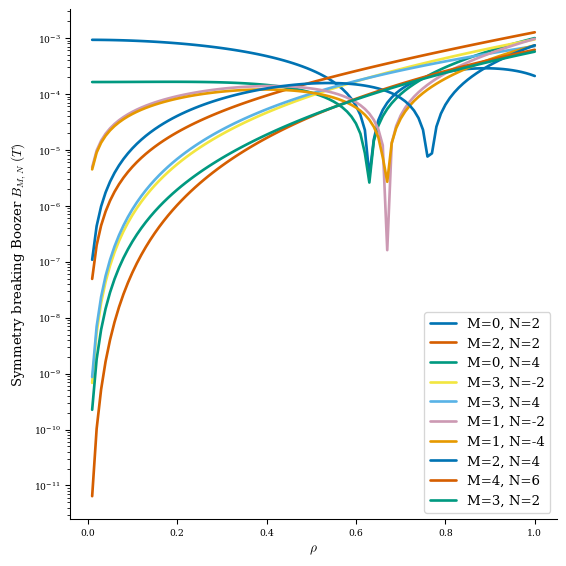

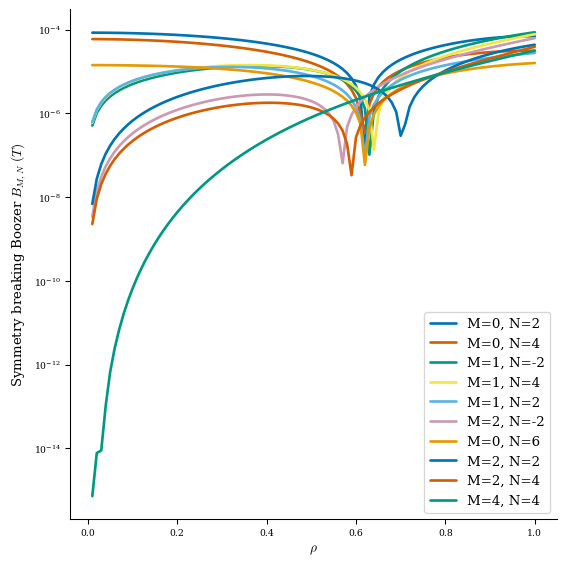

In [27]:
rho = 100
plot_boozer_modes(eq, helicity=(1, 0), rho=rho)
plot_boozer_modes(eqh, helicity=(1, 0), rho=rho);

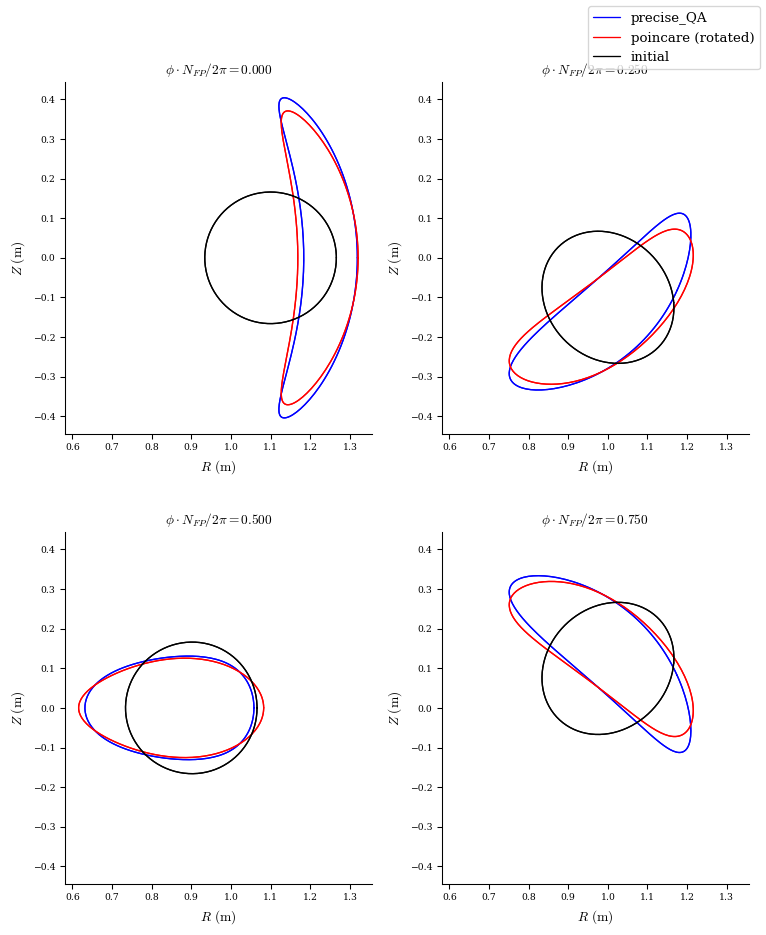

In [25]:
plot_comparison(
    [eqh, eq_rotated, eq0],
    labels=["precise_QA", "poincare (rotated)", "initial"],
    color=["blue", "red", "black"],
    theta=0,
    rho=1,
    phi=4,
);
plt.savefig("surface_poincare_optimize_QA_wqs1.0_war10.0_wvol10.0_wiota20.0.png", dpi=400)

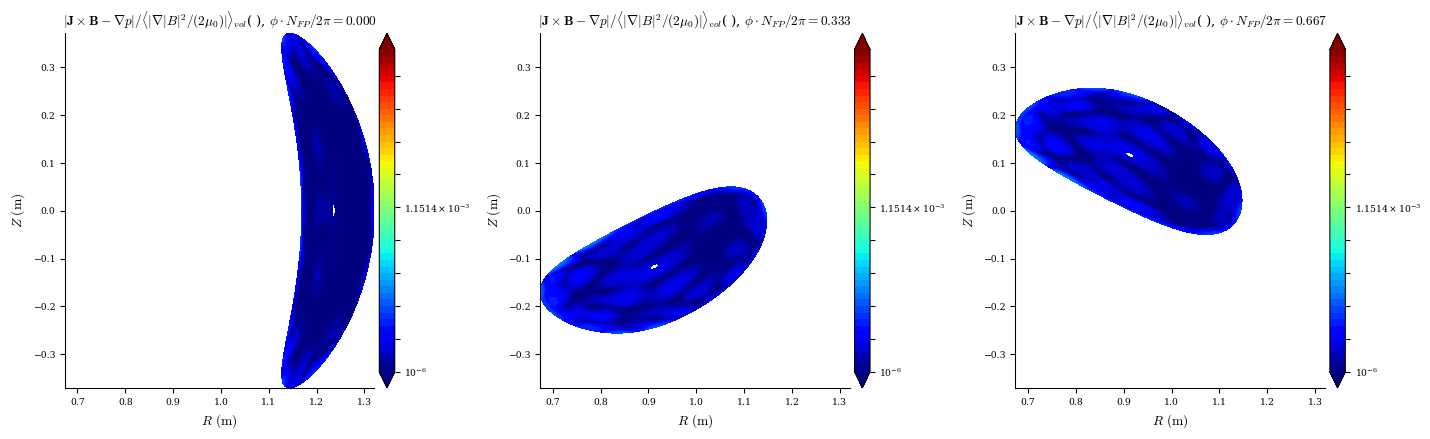

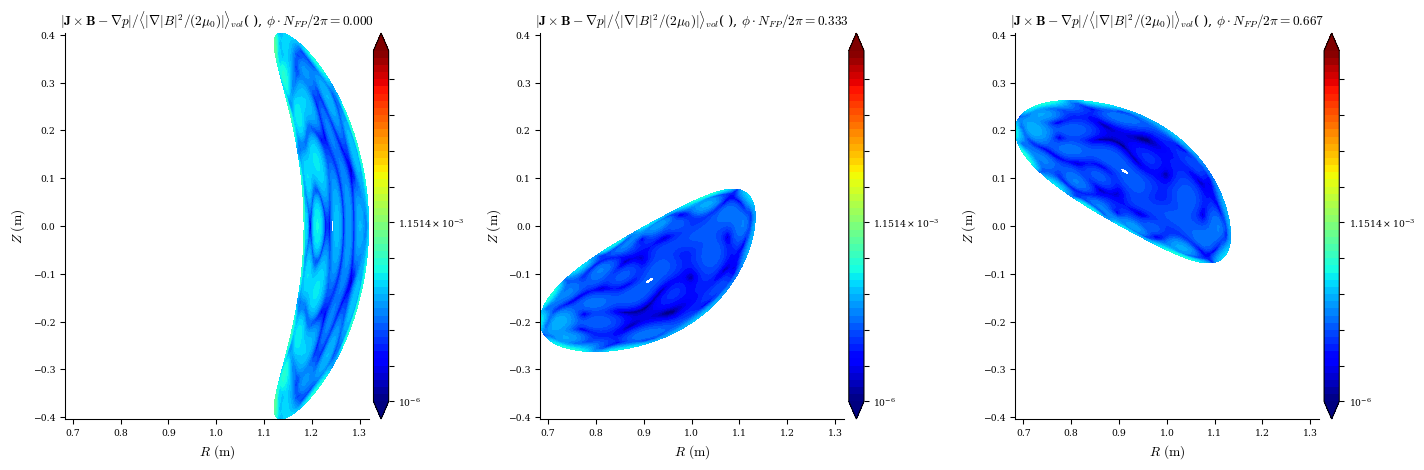

In [26]:
levels = np.logspace(-6, 0, 50)
plot_section(eq_rotated, "|F|_normalized", log=True, levels=levels, phi=3)
plt.savefig(
    "force_poincare_optimize_QA_wqs1.0_war10.0_wvol10.0_wiota20.0.png", dpi=500
)
plot_section(eqh, "|F|_normalized", log=True, levels=levels, phi=3)
plt.savefig("force_precise_QA.png", dpi=500)

(<Figure size 576.113x576.113 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

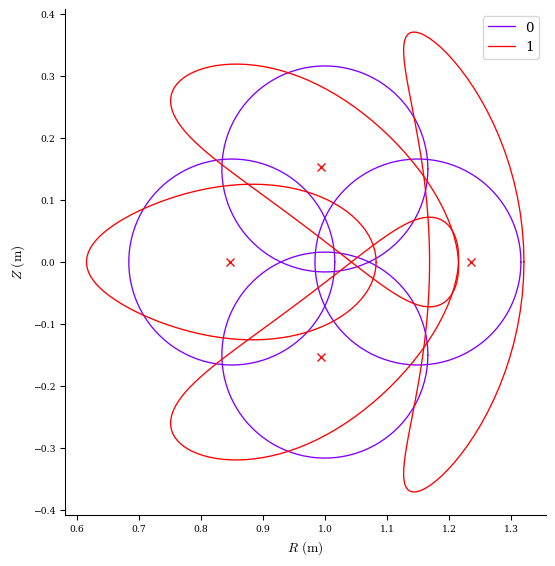

In [43]:
rmin = 0.166
rmaj = 1
dz = 0.15
surf = FourierRZToroidalSurface(
    R_lmn=[1, rmin, dz],
    Z_lmn=[-rmin, -dz],
    modes_R=[[0, 0], [1, 0], [0, 1]],
    modes_Z=[[-1, 0], [0, -1]],
    NFP=2,
)
plot_boundaries([surf, eq])